In [1]:
from __future__ import annotations

import argparse
from logging import INFO, FileHandler, getLogger

import yaml

from config.config import Config
from src.data_collaboration import DataCollaborationAnalysis
from src.load_data import load_data # , load_data_breast_cancer, load_data_diabetes, load_data_har
from src.paths import CONFIG_DIR, INPUT_DIR, OUTPUT_DIR
from src.institutional_analysis import centralize_analysis, dca_analysis, individual_analysis

import sys
sys.argv = ["notebook", "exp004"]
parser = argparse.ArgumentParser()
parser.add_argument("name", type=str)
args = parser.parse_args()


import os 
child_path = os.getcwd()
# 親ディレクトリを取得
parent_path = os.path.dirname(child_path)

# カレントディレクトリを移動
os.chdir(parent_path)

# 引数の設定
parser = argparse.ArgumentParser()
parser.add_argument("name", type=str, default="exp004")
args = parser.parse_args()
# yaml のパスと出力先パス
cfg_path    = CONFIG_DIR / f"{args.name}.yaml"
output_path = OUTPUT_DIR / args.name

# UTF-8 で読み込んで Config を生成
with cfg_path.open(encoding="utf-8") as f:
    cfg_dict = yaml.safe_load(f)

config = Config(**cfg_dict,
                output_path=output_path,
                input_path=INPUT_DIR)


# 出力ディレクトリ作成
output_path.mkdir(parents=True, exist_ok=True)

# ログの設定
logger = getLogger(__name__)
logger.setLevel(INFO)
handler = FileHandler(filename=config.output_path / "result.log", encoding="utf-8")
logger.addHandler(handler)
# UTF-8 で読み込んで Config を生成
with cfg_path.open(encoding="utf-8") as f:
    cfg_dict = yaml.safe_load(f)

train_df, test_df = load_data(config=config)
train_df

,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,target
0,5.313,3.4571,1,0,0,0,2,35.3,0,4,...,2,0,2,4.735,3.477,0,9.513,0,0,1
1,4.517,2.6567,1,0,0,0,1,44.4,1,0,...,0,0,0,3.622,2.086,0,8.370,0,1,0
2,4.985,2.5536,0,0,3,0,3,50.0,0,0,...,1,2,2,3.765,2.077,1,8.528,0,0,0
3,3.902,2.6931,2,0,0,0,0,30.8,2,0,...,0,0,0,3.547,2.022,0,8.444,0,2,0
4,4.414,3.4137,0,0,0,0,0,33.3,2,2,...,0,0,0,3.426,3.262,0,7.758,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,4.982,2.8025,0,0,2,0,2,50.0,0,2,...,0,2,1,3.853,2.833,1,8.508,0,0,1
516,4.732,3.2417,0,0,2,0,2,37.5,0,0,...,2,4,4,3.655,2.417,2,7.973,0,0,0
517,4.887,2.2910,2,0,2,0,6,44.8,0,0,...,4,4,4,3.954,2.337,2,9.239,0,2,0
518,4.380,3.3996,0,0,0,0,0,30.8,1,4,...,0,0,1,3.379,3.028,0,8.090,0,0,1


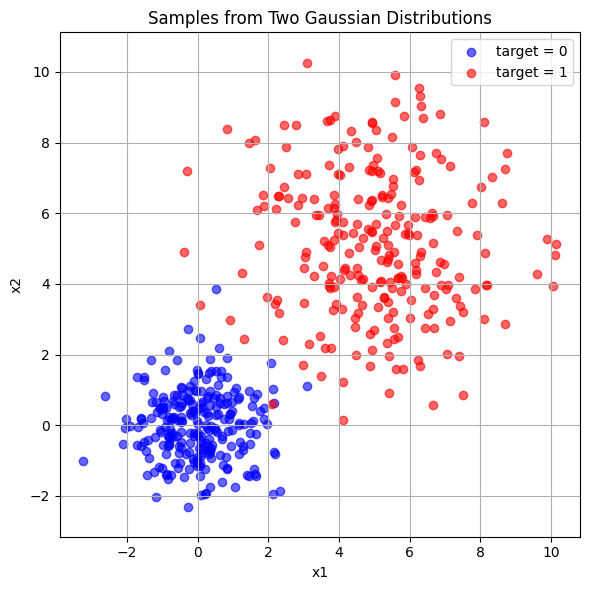

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _load_concentric_circles_df(n_samples: int = 500) -> pd.DataFrame:
    np.random.seed(42)  # 再現性のためにシード固定

    # 分布1: 中心 (0, 0), 単位分散
    n1 = n_samples // 2
    mean1 = np.array([0, 0])
    cov1 = np.eye(2)
    X1 = np.random.multivariate_normal(mean1, cov1, size=n1)
    y1 = np.zeros(n1, dtype=int)

    # 分布2: 中心 (5, 5), 分散2
    n2 = n_samples - n1
    mean2 = np.array([5, 5])
    cov2 = 4 * np.eye(2)
    X2 = np.random.multivariate_normal(mean2, cov2, size=n2)
    y2 = np.ones(n2, dtype=int)

    # 結合
    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2))

    df = pd.DataFrame(X, columns=["x1", "x2"])
    df["target"] = y
    return df

# ---------- データ生成 ----------
df = _load_concentric_circles_df()

# ---------- 可視化 ----------
plt.figure(figsize=(6, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    subset = df[df['target'] == label]
    plt.scatter(subset['x1'], subset['x2'], label=f"target = {label}", color=color, alpha=0.6)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples from Two Gaussian Distributions")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()
df.to_csv("Two_Gaussian_Distributions.csv", index=False)

In [8]:
import numpy as np
import pandas as pd

def _load_3d_gaussian_clusters_df(n_samples: int = 600) -> pd.DataFrame:
    np.random.seed(42)
    n_per_class = n_samples // 3

    # 分布1: 中心 (0, 0, 0)
    mean1 = [0, 0, 0]
    cov1 = np.eye(3)
    X1 = np.random.multivariate_normal(mean1, cov1, size=n_per_class)
    y1 = np.zeros(n_per_class, dtype=int)

    # 分布2: 中心 (5, 5, 5)
    mean2 = [5, 5, 5]
    cov2 = np.eye(3) * 1.5
    X2 = np.random.multivariate_normal(mean2, cov2, size=n_per_class)
    y2 = np.ones(n_per_class, dtype=int)

    # 分布3: 中心 (-5, 5, -5)
    mean3 = [-5, 5, -5]
    cov3 = np.eye(3) * 2
    X3 = np.random.multivariate_normal(mean3, cov3, size=n_samples - 2*n_per_class)
    y3 = np.full(n_samples - 2*n_per_class, 2, dtype=int)

    # 結合
    X = np.vstack((X1, X2, X3))
    y = np.concatenate((y1, y2, y3))

    df = pd.DataFrame(X, columns=["x1", "x2", "x3"])
    df["target"] = y
    return df


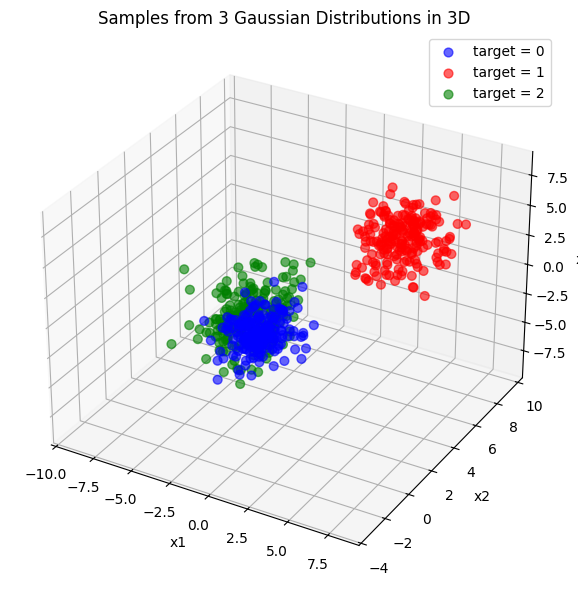

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 必須

# データ生成
df = _load_3d_gaussian_clusters_df()

# 可視化
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'red', 'green']
for label in df["target"].unique():
    subset = df[df["target"] == label]
    ax.scatter(subset["x1"], subset["x2"], subset["x3"],
               label=f"target = {label}", color=colors[label], alpha=0.6, s=40)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_title("Samples from 3 Gaussian Distributions in 3D")
ax.legend()
plt.tight_layout()
plt.show()
df.to_csv("3D_Gaussian_Clusters.csv", index=False)


In [5]:
df 

,x1,x2,target
0,0.496714,-0.138264,0
1,0.647689,1.523030,0
2,-0.234153,-0.234137,0
3,1.579213,0.767435,0
4,-0.469474,0.542560,0
...,...,...,...
495,5.416766,0.916530,1
496,4.505645,3.636032,1
497,2.996760,4.437799,1
498,8.595373,6.281686,1


In [19]:
import numpy as np
import pandas as pd

def _load_3d_8gaussian_clusters_df(n_samples: int = 8000) -> pd.DataFrame:
    np.random.seed(42)
    n_per_class = n_samples // 8

    means = [
        [0, 0, 0],
        [5, 5, 5],
        [-5, 5, -5],
        [5, -5, 5],
        [-5, -5, -5],
        [7, 0, -7],
        [-7, 7, 0],
        [0, -7, 7]
    ]

    cov = np.eye(3) * 3  # 全クラスタで共通の分散

    X_all = []
    y_all = []

    for i, mean in enumerate(means):
        X = np.random.multivariate_normal(mean, cov, size=n_per_class)
        y = np.full(n_per_class, i)
        X_all.append(X)
        y_all.append(y)

    X = np.vstack(X_all)
    y = np.concatenate(y_all)

    df = pd.DataFrame(X, columns=["x1", "x2", "x3"])
    df["target"] = y
    return df


C:\Users\sueya\AppData\Local\Temp\ipykernel_24016\1149639130.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", 8)  # 8色取得


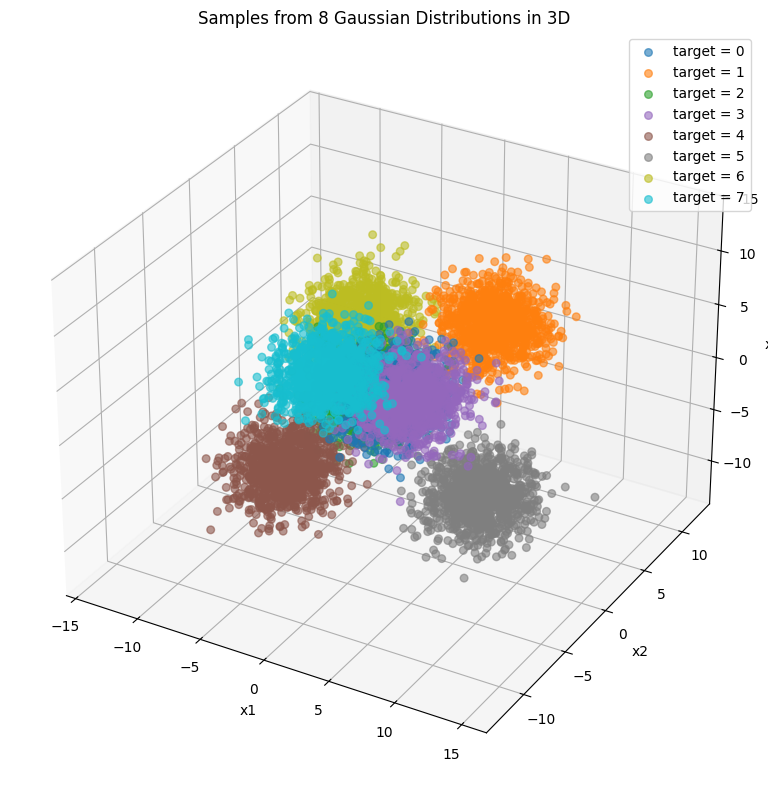

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# データ生成
df = _load_3d_8gaussian_clusters_df()

# 可視化
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.get_cmap("tab10", 8)  # 8色取得

for label in sorted(df["target"].unique()):
    subset = df[df["target"] == label]
    ax.scatter(subset["x1"], subset["x2"], subset["x3"],
               label=f"target = {label}",
               color=colors(label), alpha=0.6, s=30)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_title("Samples from 8 Gaussian Distributions in 3D")
ax.legend()
plt.tight_layout()
plt.show()
df.to_csv("3D_8_Gaussian_Clusters.csv", index=False)

In [21]:
df

,x1,x2,x3,target
0,0.860334,-0.239481,1.121829,0
1,2.637965,-0.405566,-0.405537,0
2,2.735277,1.329236,-0.813153,0
3,0.939742,-0.802663,-0.806668,0
4,0.419091,-3.313899,-2.987645,0
...,...,...,...,...
7995,-1.623984,-5.975609,6.110334,7
7996,1.230646,-6.481403,10.206293,7
7997,0.908179,-5.070118,7.696085,7
7998,0.539349,-4.982623,8.158391,7


In [15]:
import pandas as pd
time_df = pd.read_csv(config.output_path / "timing.csv", index_col=0)

NameError: name 'config' is not defined

In [3]:
config.dataset

'har'

In [5]:
time_df 

,func,name,dataset,seed,num_institution,num_institution_user,num_anchor_data,dim_intermediate,dim_integrate,y_name,h_model,output_path,input_path,F_type,G_type
elapsed_ms,,,,,,,,,,,,,,,
407.944,make_integrate_expression,partial_run,qsar,43,1,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,Imakura
1.653,make_integrate_expression_gen_eig,partial_run,qsar,43,1,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,GEP
767.153,make_integrate_expression,partial_run,qsar,43,2,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,Imakura
5.680,make_integrate_expression_gen_eig,partial_run,qsar,43,2,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,GEP
1094.421,make_integrate_expression,partial_run,qsar,43,3,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,Imakura
9.555,make_integrate_expression_gen_eig,partial_run,qsar,43,3,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,GEP
1309.396,make_integrate_expression,partial_run,qsar,43,4,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,Imakura
12.306,make_integrate_expression_gen_eig,partial_run,qsar,43,4,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,GEP
1165.509,make_integrate_expression,partial_run,qsar,43,5,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,Imakura


In [ ]:
time_df.columns

Index(['func', 'name', 'dataset', 'seed', 'num_institution',
       'num_institution_user', 'num_anchor_data', 'dim_intermediate',
       'dim_integrate', 'y_name', 'h_model', 'output_path', 'input_path',
       'F_type', 'G_type'],
      dtype='object')

In [ ]:
time_df

,func,name,dataset,seed,num_institution,num_institution_user,num_anchor_data,dim_intermediate,dim_integrate,y_name,h_model,output_path,input_path,F_type,G_type
elapsed_ms,,,,,,,,,,,,,,,
68.692,make_integrate_expression_gen_eig,exp004,qsar,43,10,50,3000,40,40,target,random_forest,C:\Users\sueya\Git-Repositories\takano_labo\dc...,C:\Users\sueya\Git-Repositories\takano_labo\dc...,svd,GEP_weighted


In [ ]:
# インスタンスの生成
data_collaboration = DataCollaborationAnalysis(config=config, logger=logger, train_df=train_df, test_df=test_df)

# データ分割 -> 統合表現の獲得まで一気に実行
data_collaboration.run()

********************データの分割********************


100%|██████████| 10/10 [00:00<00:00, 1701.89it/s]


num_row 3000 num_col 48
anchor [[0.11505457 0.60906654 0.13339096 ... 0.27555878 0.89674727 0.20689137]
 [0.40440524 0.99357249 0.73572708 ... 0.73986382 0.18471296 0.43467832]
 [0.8858995  0.25504628 0.44331269 ... 0.07755781 0.48690618 0.46819391]
 ...
 [0.17622189 0.81609769 0.35492882 ... 0.14924751 0.76343085 0.05190865]
 [0.20058071 0.45928436 0.12640881 ... 0.25942627 0.67589441 0.14764702]
 [0.97560645 0.94663338 0.81721479 ... 0.55127237 0.08843842 0.92236722]]
Xs_train[0].shape (50, 48) Xs_test[0].shape (50, 48)
********************中間表現の生成********************
Config(name='exp004', dataset='statlog', num_institution=10, num_institution_user=50, num_anchor_data=3000, dim_intermediate=30, dim_integrate=30, y_name='target', h_model='random_forest', output_path=WindowsPath('C:/Users/sueya/Git-Repositories/takano_labo/dca_yanagi/output/exp004'), input_path=WindowsPath('C:/Users/sueya/Git-Repositories/takano_labo/dca_yanagi/input'), seed=43)
self.config.dim_intermediate 30



100%|██████████| 10/10 [00:00<00:00, 205.80it/s]


中間表現の次元数:  48
********************統合表現の生成********************


100%|██████████| 10/10 [00:00<00:00, 29.80it/s]

統合表現の次元数:  48


In [ ]:
import os 
child_path = os.getcwd()
# 親ディレクトリを取得
parent_path = os.path.dirname(child_path)

# カレントディレクトリを移動
os.chdir(parent_path)
columns = [
        "SpMax_L", "J_Dz(e)", "nHM", "F01[N-N]", "F04[C-N]", "NssssC", "nCb-", "C%",
        "nCp", "nO", "F03[C-N]", "SdssC", "HyWi_B(m)", "LOC", "SM6_L", "F03[C-O]",
        "Me", "Mi", "nN-N", "nArNO2", "nCRX3", "SpPosA_B(p)", "nCIR", "B01[C-Br]",
        "B03[C-Cl]", "N-073", "SpMax_A", "Psi_i_1d", "B04[C-Br]", "SdO", "TI2_L",
        "nCrt", "C-026", "F02[C-N]", "nHDon", "SpMax_B(m)", "Psi_i_A", "nN",
        "SM6_B(m)", "nArCOOR", "nX", "target"
    ]
import pandas as pd
# データ読み込み（区切り文字は ';'）
df = pd.read_csv("input/qsar+biodegradation/biodeg.csv", header=None, sep=";")
df.columns = columns

# ターゲット変換：RB → 1（ready biodeg）、NRB → 0（not ready）
df["target"] = df["target"].map({"RB": 1, "NRB": 0})

In [ ]:
df

,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,target
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,1
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,1
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,1
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,1
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,5.431,2.8955,0,0,0,2,0,32.1,4,1,...,0,6,1,3.573,2.242,1,8.088,0,0,0
1051,5.287,3.3732,0,0,9,0,0,35.3,0,9,...,0,3,0,3.787,3.083,3,9.278,0,0,0
1052,4.869,1.7670,0,1,9,0,5,44.4,0,4,...,4,13,0,3.848,2.576,5,9.537,1,0,0
1053,5.158,1.6914,2,0,36,0,9,56.1,0,0,...,1,16,0,5.808,2.055,8,11.055,0,1,0


In [ ]:
data_collaboration.X_train_integ

array([[12, 2390, 4, ..., False, True, False],
       [12, 1493, 4, ..., False, False, False],
       [36, 2820, 4, ..., False, False, False],
       ...,
       [60, 7418, 1, ..., False, False, False],
       [30, 4249, 4, ..., True, False, False],
       [12, 886, 4, ..., False, False, False]], dtype=object)

In [ ]:
data_collaboration.train_df

,col1,col4,col7,col10,col12,col15,col17,col0_A12,col0_A13,col0_A14,...,col13_A142,col13_A143,col14_A152,col14_A153,col16_A172,col16_A173,col16_A174,col18_A192,col19_A202,target
0,12,2390,4,3,50,1,1,False,False,True,...,False,True,True,False,False,True,False,True,False,1
1,12,1493,4,3,34,1,2,False,False,True,...,False,True,True,False,False,True,False,False,False,1
2,36,2820,4,4,27,2,1,True,False,False,...,False,True,True,False,False,True,False,False,False,2
3,24,11560,1,4,23,2,1,True,False,False,...,False,True,False,False,False,False,True,False,False,2
4,15,2728,4,2,35,3,1,True,False,False,...,False,False,True,False,False,True,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,12,1262,2,4,49,1,1,False,False,False,...,False,True,True,False,True,False,False,True,False,1
496,6,1554,1,2,24,2,1,False,False,True,...,False,True,False,False,False,True,False,True,False,1
497,60,7418,1,1,27,1,1,True,False,False,...,False,True,True,False,True,False,False,False,False,1
498,30,4249,4,2,28,2,1,True,False,False,...,False,True,True,False,False,False,True,False,False,2


In [ ]:
# 集中解析
centralize_analysis(config, logger, y_name=config.y_name)

# 個別解析
individual_analysis(
config=config,
logger=logger,
Xs_train=data_collaboration.Xs_train,
ys_train=data_collaboration.ys_train,
Xs_test=data_collaboration.Xs_test,
ys_test=data_collaboration.ys_test,

)

# 提案手法
dca_analysis(
    X_train_integ=data_collaboration.X_train_integ,
    X_test_integ=data_collaboration.X_test_integ,
    y_train_integ=data_collaboration.y_train_integ,
    y_test_integ=data_collaboration.y_test_integ,
    config=config,
    logger=logger,
)

y_name = 'target'
train_df = train_df.copy()
test_df = test_df.copy()
y_train = train_df[y_name]
X_train = train_df.drop(y_name, axis=1)
y_test = test_df[y_name]
X_test = test_df.drop(y_name, axis=1)

# 提案手法
dca_analysis(
    X_train_integ=X_train,
    y_train_integ=y_train,
    X_test_integ=X_test,
    y_test_integ=y_test,
    config=config,
    logger=logger,
)

# train_df, test_df = load_data(config=config)
# y_name = config.y_name
# y_train = train_df.pop(y_name).values
# y_test = test_df.pop(y_name).values

# X_train = train_df.values
# X_test = test_df.values
# dca_analysis(
#     X_train_integ=X_train,
#     y_train_integ=y_train,
#     X_test_integ=X_test,
#     y_test_integ=y_test,
#     config=config,
#     logger=logger,
# )



In [ ]:
import numpy as np
model = data_collaboration

# ① 元の訓練特徴行列（DataFrame → ndarray）
X_train_df_vals = model.train_df.drop(columns=model.config.y_name).values

# ② 統合後の訓練特徴行列
X_train_integ = model.X_train_integ

# 形状が同じか
print("shape:", X_train_df_vals.shape, X_train_integ.shape)

# 完全一致判定（dtype も含めて）
is_equal = np.array_equal(X_train_df_vals, X_train_integ)
print("完全一致？", is_equal)

# 数値誤差込みで確認したい場合（浮動小数点誤差が気になるとき）
is_close = np.allclose(X_train_df_vals, X_train_integ, atol=1e-12)
print("allclose？", is_close)

# もし False なら差分の最大値を見る
if not is_equal:
    diff_max = np.abs(X_train_df_vals - X_train_integ).max()
    print("要素差の最大値:", diff_max)

shape: (500, 48) (500, 48)
完全一致？ True


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
self = data_collaboration
self.Xs_train, self.Xs_test, self.ys_train, self.ys_test = self.train_test_split(
    train_df=self.train_df,
    test_df=self.test_df,
    num_institution=self.config.num_institution,
    num_institution_user=self.config.num_institution_user,
    y_name=self.config.y_name,
)

********************データの分割********************


100%|██████████| 9/9 [00:00<00:00, 520.47it/s]


In [ ]:
self.train_df

,subject,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",target
0,5,0.260480,-0.032310,-0.066292,-0.976873,-0.779216,-0.874830,-0.978905,-0.779862,-0.877856,...,0.201887,-0.188315,0.087804,0.020336,0.085813,-0.361440,-0.908870,0.141712,-0.030348,5
1,30,0.275524,-0.014530,-0.094176,-0.997408,-0.969633,-0.988884,-0.998142,-0.970498,-0.989849,...,-0.381182,-0.808719,0.030250,0.238178,0.707377,0.885212,-0.934482,0.117491,-0.026064,5
2,12,0.284224,0.001572,-0.099114,-0.099672,-0.094548,-0.578631,-0.155997,-0.153726,-0.576249,...,-0.083218,-0.480254,0.003401,-0.944625,-0.700109,0.015062,-0.872035,0.185065,0.035282,1
3,1,0.237154,0.007825,-0.122838,-0.979954,-0.866193,-0.968290,-0.980179,-0.882316,-0.966097,...,-0.444482,-0.816502,0.321250,-0.050328,0.584280,-0.426198,-0.654356,0.006141,-0.212753,4
4,1,0.285415,0.016834,-0.106884,-0.324009,0.129619,-0.012624,-0.354572,0.098502,0.073785,...,-0.732537,-0.960982,0.192449,-0.317324,-0.949011,0.560496,-0.609545,0.361467,0.075794,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,3,0.262230,-0.016215,-0.139427,-0.416786,-0.106049,-0.312882,-0.449481,-0.124725,-0.277529,...,0.244469,-0.074119,0.065696,0.137927,0.972675,-0.551858,-0.575794,0.351126,0.165120,2
5054,24,0.258587,-0.006958,-0.094029,-0.485825,-0.255627,-0.287639,-0.494420,-0.262824,-0.292375,...,0.395960,0.205011,0.449331,-0.357677,0.973246,-0.461628,-0.808655,0.180537,0.125777,1
5055,3,0.281441,0.022608,-0.005444,-0.342525,-0.080141,-0.419493,-0.372983,-0.097087,-0.438115,...,0.022938,-0.327122,0.140679,-0.830736,-0.749077,0.246029,-0.730683,0.262451,0.107399,1
5056,17,0.269284,-0.019122,-0.119044,-0.993520,-0.971380,-0.981386,-0.993374,-0.969525,-0.980839,...,-0.808637,-0.955617,0.031545,-0.104858,0.336990,0.435159,-0.595726,0.225426,0.274263,5


In [ ]:
(self.Xs_train[0]).shape

In [ ]:
(self.Xs_train[0]).shape

(562, 562)

In [ ]:
data_collaboration.X_train_integ

array([[-0.02199168, -0.00193741,  0.03037781, ...,  0.02089628,
        -0.02949354, -0.0365137 ],
       [-0.0215623 ,  0.1480495 ,  0.00143068, ...,  0.09192154,
        -0.17395793, -0.13523286],
       [-0.01261774,  0.06383755, -0.01167625, ...,  0.02984417,
        -0.07177247, -0.08207228],
       ...,
       [-0.01445803,  0.00931933,  0.01107408, ...,  0.02749681,
        -0.00056695, -0.01858404],
       [-0.0222488 ,  0.07548985,  0.01232103, ...,  0.07996689,
        -0.07128218, -0.06238973],
       [-0.00951358,  0.12734982, -0.0256818 , ...,  0.14801013,
        -0.106917  , -0.0707165 ]])

In [ ]:
 train_df

,subject,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",target
0,5,0.260480,-0.032310,-0.066292,-0.976873,-0.779216,-0.874830,-0.978905,-0.779862,-0.877856,...,0.201887,-0.188315,0.087804,0.020336,0.085813,-0.361440,-0.908870,0.141712,-0.030348,5
1,30,0.275524,-0.014530,-0.094176,-0.997408,-0.969633,-0.988884,-0.998142,-0.970498,-0.989849,...,-0.381182,-0.808719,0.030250,0.238178,0.707377,0.885212,-0.934482,0.117491,-0.026064,5
2,12,0.284224,0.001572,-0.099114,-0.099672,-0.094548,-0.578631,-0.155997,-0.153726,-0.576249,...,-0.083218,-0.480254,0.003401,-0.944625,-0.700109,0.015062,-0.872035,0.185065,0.035282,1
3,1,0.237154,0.007825,-0.122838,-0.979954,-0.866193,-0.968290,-0.980179,-0.882316,-0.966097,...,-0.444482,-0.816502,0.321250,-0.050328,0.584280,-0.426198,-0.654356,0.006141,-0.212753,4
4,1,0.285415,0.016834,-0.106884,-0.324009,0.129619,-0.012624,-0.354572,0.098502,0.073785,...,-0.732537,-0.960982,0.192449,-0.317324,-0.949011,0.560496,-0.609545,0.361467,0.075794,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,3,0.262230,-0.016215,-0.139427,-0.416786,-0.106049,-0.312882,-0.449481,-0.124725,-0.277529,...,0.244469,-0.074119,0.065696,0.137927,0.972675,-0.551858,-0.575794,0.351126,0.165120,2
5054,24,0.258587,-0.006958,-0.094029,-0.485825,-0.255627,-0.287639,-0.494420,-0.262824,-0.292375,...,0.395960,0.205011,0.449331,-0.357677,0.973246,-0.461628,-0.808655,0.180537,0.125777,1
5055,3,0.281441,0.022608,-0.005444,-0.342525,-0.080141,-0.419493,-0.372983,-0.097087,-0.438115,...,0.022938,-0.327122,0.140679,-0.830736,-0.749077,0.246029,-0.730683,0.262451,0.107399,1
5056,17,0.269284,-0.019122,-0.119044,-0.993520,-0.971380,-0.981386,-0.993374,-0.969525,-0.980839,...,-0.808637,-0.955617,0.031545,-0.104858,0.336990,0.435159,-0.595726,0.225426,0.274263,5


In [ ]:
train_df

,subject,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",target
0,5,0.260480,-0.032310,-0.066292,-0.976873,-0.779216,-0.874830,-0.978905,-0.779862,-0.877856,...,0.201887,-0.188315,0.087804,0.020336,0.085813,-0.361440,-0.908870,0.141712,-0.030348,5
1,30,0.275524,-0.014530,-0.094176,-0.997408,-0.969633,-0.988884,-0.998142,-0.970498,-0.989849,...,-0.381182,-0.808719,0.030250,0.238178,0.707377,0.885212,-0.934482,0.117491,-0.026064,5
2,12,0.284224,0.001572,-0.099114,-0.099672,-0.094548,-0.578631,-0.155997,-0.153726,-0.576249,...,-0.083218,-0.480254,0.003401,-0.944625,-0.700109,0.015062,-0.872035,0.185065,0.035282,1
3,1,0.237154,0.007825,-0.122838,-0.979954,-0.866193,-0.968290,-0.980179,-0.882316,-0.966097,...,-0.444482,-0.816502,0.321250,-0.050328,0.584280,-0.426198,-0.654356,0.006141,-0.212753,4
4,1,0.285415,0.016834,-0.106884,-0.324009,0.129619,-0.012624,-0.354572,0.098502,0.073785,...,-0.732537,-0.960982,0.192449,-0.317324,-0.949011,0.560496,-0.609545,0.361467,0.075794,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,3,0.262230,-0.016215,-0.139427,-0.416786,-0.106049,-0.312882,-0.449481,-0.124725,-0.277529,...,0.244469,-0.074119,0.065696,0.137927,0.972675,-0.551858,-0.575794,0.351126,0.165120,2
5054,24,0.258587,-0.006958,-0.094029,-0.485825,-0.255627,-0.287639,-0.494420,-0.262824,-0.292375,...,0.395960,0.205011,0.449331,-0.357677,0.973246,-0.461628,-0.808655,0.180537,0.125777,1
5055,3,0.281441,0.022608,-0.005444,-0.342525,-0.080141,-0.419493,-0.372983,-0.097087,-0.438115,...,0.022938,-0.327122,0.140679,-0.830736,-0.749077,0.246029,-0.730683,0.262451,0.107399,1
5056,17,0.269284,-0.019122,-0.119044,-0.993520,-0.971380,-0.981386,-0.993374,-0.969525,-0.980839,...,-0.808637,-0.955617,0.031545,-0.104858,0.336990,0.435159,-0.595726,0.225426,0.274263,5
